In [28]:
## imports

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


In [ ]:
## USing data with encoders

out = np.load('disc-benchmark-files/training-val-test-data.npz')
th_train = out['th'] 
u_train = out['u'] 

# Normalise the data

maxu = np.max(np.abs(u_train))
maxth = np.max(np.abs(th_train))

u_train = u_train/maxu
th_train = th_train/maxth

print(np.min(u_train), np.max(u_train))
print(np.min(th_train), np.max(th_train))


-0.9297032580895223 1.0
-0.8717579250720461 1.0


In [ ]:
def make_OE_data(udata, ydata, nf=100,n_encode = 15):
    U = []
    Y = []
    H = []
    for k in range(nf+n_encode,len(udata)):
        U.append(udata[k-nf-1:k-1]) 
        Y.append(ydata[k-nf:k]) 
        H.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf])))
    return np.array(U), np.array(Y), np.array(H)

# Modify training dataset for training and validation
nf = 1
ne = 15
utrain,ttrain,htrain =make_OE_data(u_train, th_train, nf,ne)
Ut,Uv,Yt,Yv,Ht,Hv = train_test_split(utrain,ttrain,htrain,shuffle=True)
Ut = torch.tensor(Ut)
Uv = torch.tensor(Uv)
Yt = torch.tensor(Yt)
Yv = torch.tensor(Yv)
Ht = torch.tensor(Ht)
Hv = torch.tensor(Hv)
# check if correct shape 
print(f"Ut: {Ut.shape},Uv: {Uv.shape}")
print(f"Yt: {Yt.shape},Yv: {Yv.shape}")
print(f"Ht: {Ht.shape},Hv: {Hv.shape}")
print(Ut[0])
print(Ht[0])
print(Yt[0])
print(Ut[1])
print(Ht[1])
print(Yt[1])


Ut: torch.Size([26238, 1]),Uv: torch.Size([8746, 1])
Yt: torch.Size([26238, 1]),Yv: torch.Size([8746, 1])
Ht: torch.Size([26238, 30]),Hv: torch.Size([8746, 30])
tensor([0.3359], dtype=torch.float64)
tensor([ 0.0480, -0.0087, -0.0816, -0.1596, -0.2300, -0.2806, -0.3016, -0.2873,
        -0.2372, -0.1556, -0.0518,  0.0622,  0.1728,  0.2673,  0.3359,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0014, -0.0029, -0.0072, -0.0173,
        -0.0288, -0.0432, -0.0562, -0.0634, -0.0634, -0.0548],
       dtype=torch.float64)
tensor([-0.0360], dtype=torch.float64)
tensor([0.3727], dtype=torch.float64)
tensor([-0.0087, -0.0816, -0.1596, -0.2300, -0.2806, -0.3016, -0.2873, -0.2372,
        -0.1556, -0.0518,  0.0622,  0.1728,  0.2673,  0.3359,  0.3727,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0014, -0.0029, -0.0072, -0.0173, -0.0288,
        -0.0432, -0.0562, -0.0634, -0.0634, -0.0548, -0.0360],
       dtype=torch.float64)
tensor([-0.0086], dtype=torch.float64)


In [31]:

ufull = torch.tensor(utrain)
yfull = torch.tensor(ttrain)
hfull = torch.tensor(htrain)
print(ufull.shape)
print(yfull.shape)
print(hfull.shape)

torch.Size([34984, 1])
torch.Size([34984, 1])
torch.Size([34984, 30])


In [32]:
class RNN(nn.Module):
    def __init__(self, hidden_size, n_enc):
        super(RNN, self).__init__()
        self.input_size = 1
        self.output_size = 1
        #self.hidden_size = hidden_size
        self.hh = 32

        self.h2h =nn.Sequential(nn.Linear(self.input_size + hidden_size,self.hh),
                                               nn.ReLU(),
                                               nn.Linear(self.hh,hidden_size)).double()

        self.h2o =  nn.Sequential(nn.Linear(self.input_size + hidden_size,3*self.hh),
                                               nn.ReLU(),
                                               nn.Linear(3*self.hh,2*self.hh),
                                               nn.ReLU(),
                                               nn.Linear(2*self.hh,self.hh),
                                               nn.ReLU(),
                                               nn.Linear(self.hh,self.output_size)).double()
        self.enc = nn.Sequential(
           nn.Linear(2*n_enc,2*self.hh),).double()
    def forward(self, x, hist):
        hidden = self.enc(hist)
        outputs = []
        for i in range(x.shape[1]):
            u = x[:,i][:,None]
            temp = torch.cat((hidden,u),1)
            outputs.append(self.h2o(temp)[:,0])
            hidden = self.h2h(temp)
        return torch.stack(outputs,dim =1)



In [33]:
epochs = 50
batch_size = 64

model =RNN(64,ne)
opt = torch.optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()
ids=np.arange(len(Ut),dtype = int)
Losses = []
Losses_val = []
for epoch in range(epochs):
    np.random.shuffle(ids)
    for i in range(0,len(ids),batch_size):
        opt.zero_grad()
        # Get batch data
        id_batch = ids[i:i+batch_size]
        Ub = Ut[id_batch]
        Hb = Ht[id_batch]
        Yb = Yt[id_batch]

        Y_pred = model(Ub,Hb)
        Loss = torch.mean((Y_pred - Yb)**2)

        Loss.backward()
        opt.step()
    with torch.no_grad():
        Loss_val = torch.mean((model(Uv,Hv) - Yv)**2)**0.5
        Loss_train = torch.mean((model(Ut,Ht) - Yt)**2)**0.5
        Losses.append(Loss_train.item())
        Losses_val.append(Loss_val.item())
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():}, Train Loss={Loss_train.item():}')

epoch=0, Validation Loss=0.0362163592266067, Train Loss=0.025929422430584936
epoch=1, Validation Loss=0.025558822912700282, Train Loss=0.01687114334126332
epoch=2, Validation Loss=0.017137227588371516, Train Loss=0.010700830321923645
epoch=3, Validation Loss=0.012741865722008005, Train Loss=0.008163737429401317
epoch=4, Validation Loss=0.010009890325590215, Train Loss=0.006437350374568288
epoch=5, Validation Loss=0.008422123160791297, Train Loss=0.005650023252576641
epoch=6, Validation Loss=0.007237963442080567, Train Loss=0.004902324455118398
epoch=7, Validation Loss=0.006568648217756443, Train Loss=0.004457350451776616
epoch=8, Validation Loss=0.005898792610699875, Train Loss=0.004233755856467314
epoch=9, Validation Loss=0.005465761768528414, Train Loss=0.00373008182760851
epoch=10, Validation Loss=0.005204170789504311, Train Loss=0.003584219173272482
epoch=11, Validation Loss=0.004716921670006861, Train Loss=0.0032683834463742584
epoch=12, Validation Loss=0.0044171095466791046, Trai

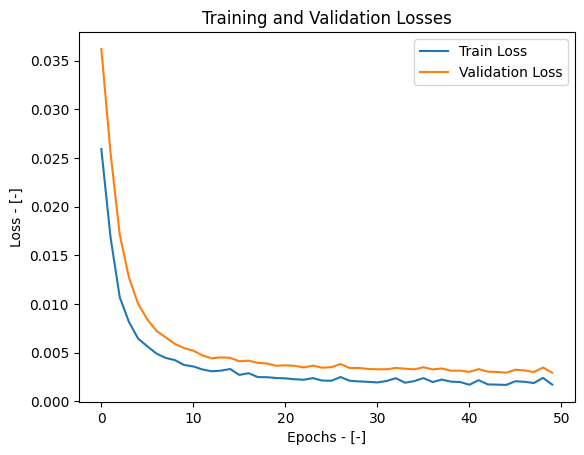

In [34]:
# Plot the losses   
plt.plot(Losses, label='Train Loss')
plt.plot(Losses_val, label='Validation Loss')
plt.xlabel('Epochs - [-]')
plt.ylabel('Loss - [-]')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

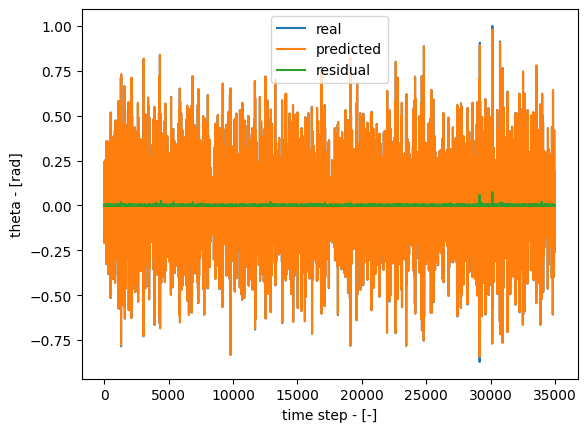

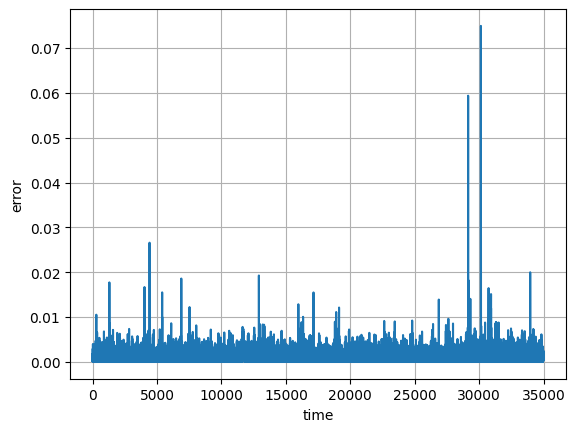

0.0020876440376791255


In [35]:


with torch.no_grad():
    plt.plot(yfull)
    plt.plot(model(ufull,hfull))
    plt.plot(np.mean((yfull-model(ufull,hfull)).numpy()**2,axis=1)**0.5)
    plt.xlabel('time step - [-]')
    plt.ylabel('theta - [rad]')
    plt.legend(['real','predicted','residual'])
    plt.show()
    plt.plot(np.mean((yfull-model(ufull,hfull)).numpy()**2,axis=1)**0.5)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.grid()
    plt.show()
    print(np.mean((yfull-model(ufull,hfull)).numpy()**2)**0.5)


In [36]:
data = np.load('disc-benchmark-files/hidden-test-prediction-submission-file.npz')
utest_pred = data['upast'] 
thtest_pred = data['thpast'] 

In [37]:
ne = 15

utest = utest_pred[:,ne-1]/maxu
maxpred = np.max(np.abs(utest_pred))
maxpredth = np.max(np.abs(thtest_pred))

htest = np.concatenate((utest_pred/maxu, thtest_pred/maxth), axis=1)
utest = torch.Tensor(utest).double().unsqueeze(1)
htest = torch.Tensor(htest).double()

print(utest[0])
print(htest[0])
tsub = model(utest,htest).detach().numpy()
print(tsub*maxth)
np.savez('submissions/advanced_pred.npz',upast =utest_pred,thpast=thtest_pred,thnow = tsub*maxth)

tensor([-0.1427], dtype=torch.float64)
tensor([ 0.1789,  0.1992,  0.1979,  0.1723,  0.1232,  0.0556, -0.0227, -0.1020,
        -0.1723, -0.2250, -0.2543, -0.2576, -0.2364, -0.1956, -0.1427,  0.0879,
         0.0159, -0.0476, -0.0980, -0.1282, -0.1398, -0.1340, -0.1153, -0.0879,
        -0.0548, -0.0231,  0.0029,  0.0216,  0.0303,  0.0288],
       dtype=torch.float64)
[[ 4.77033307e-02]
 [ 1.03373062e+00]
 [-5.04658044e-01]
 [ 7.07922654e-01]
 [-1.75200038e-01]
 [-8.57697266e-02]
 [-7.41702697e-01]
 [-4.83555675e-02]
 [ 1.72499285e-01]
 [ 1.78620426e-02]
 [ 2.67249472e-01]
 [ 3.68323572e-01]
 [-2.58549367e-01]
 [ 7.50449517e-01]
 [ 6.41674792e-02]
 [-8.20542915e-01]
 [ 3.25705588e-01]
 [ 6.93885446e-01]
 [-2.67584939e-01]
 [-5.53906363e-01]
 [ 1.56987802e+00]
 [ 3.67875802e-01]
 [ 4.26984351e-02]
 [-9.49903238e-01]
 [ 7.60520710e-02]
 [-5.00401677e-02]
 [ 2.93777121e-01]
 [-3.32699820e-01]
 [-1.89560354e-02]
 [ 1.01588759e-01]
 [ 1.72611108e-01]
 [-9.68869520e-01]
 [ 1.75107381e-01]
 [ 

(645, 1)
(645, 1)
(645, 1)
RMSE between advanced and simple prediction: 0.003338036287370637


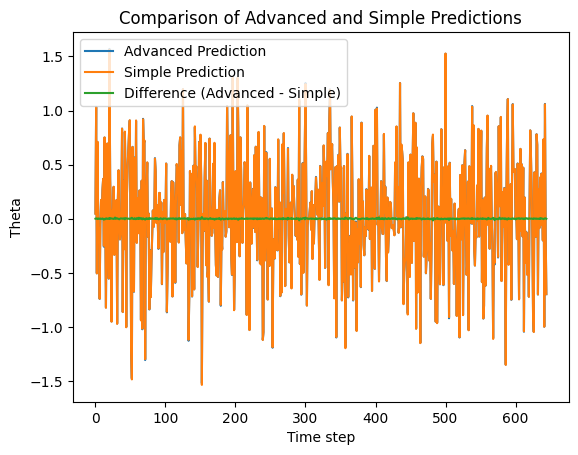

In [39]:
data = np.load('submissions/advanced_pred.npz')
data1 = np.load('submissions/simple_pred.npz')
uadv = data['thnow']
usim = data1['thnow']
print(uadv.shape)
print(usim.shape)

rmse = np.mean((uadv-usim)**2)**0.5
print((uadv-usim).shape)
print(f'RMSE between advanced and simple prediction: {rmse}')
plt.plot(uadv, label='Advanced Prediction')
plt.plot(usim, label='Simple Prediction')

plt.plot(uadv-usim, label='Difference (Advanced - Simple)')
plt.xlabel('Time step')
plt.ylabel('Theta')
plt.title('Comparison of Advanced and Simple Predictions')
plt.legend()    
plt.show()